In [12]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [13]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [14]:
from colabgymrender.recorder import Recorder

In [15]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [16]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [17]:
total_reward

  and should_run_async(code)



-200.0

In [18]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 200
num_episodes = 2400
epsilon_decay_rate = 0.99
gamma = 0.99 # discount
alpha = 0.0028 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 256

target_update_frequency = 10 # target network update frequency

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [20]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [21]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_rate, gamma, lr, num_episodes, batch_size, target_update_frequency):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100)
    all_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        epsilon = max(min_epsilon, max_epsilon * (epsilon_decay_rate ** episode))
        reward_per_episode = 0.0
        done = False

        for step in range(max_num_steps):
            exploration = random.uniform(0, 1)
            if exploration <= epsilon:
                action = env.action_space.sample()
            else:
                action = q_net.choose_action(state)

            next_state, reward, done, info = env.step(action)
            experience = (state, action, reward, done, next_state)
            memory.append(experience)
            reward_per_episode += reward

            state = next_state

            if len(memory) > batch_size:
                experiences = random.sample(memory, batch_size)
                states = torch.tensor([ex[0] for ex in experiences], dtype=torch.float32)
                actions = torch.tensor([ex[1] for ex in experiences], dtype=torch.int64).unsqueeze(-1)
                rewards = torch.tensor([ex[2] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
                dones = torch.tensor([ex[3] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
                next_states = torch.tensor([ex[4] for ex in experiences], dtype=torch.float32)

                target_q_values = target_net(next_states)
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                targets = rewards + gamma * (1 - dones) * max_target_q_values

                q_values = q_net(states)
                action_q_values = torch.gather(input=q_values, dim=1, index=actions)
                loss = torch.nn.functional.mse_loss(action_q_values, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        if (episode + 1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        reward_buffer.append(reward_per_episode)
        all_rewards.append((episode, reward_per_episode))

        if (episode + 1) % target_update_frequency == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {episode + 1}, Average reward: {average_reward}')

    return all_rewards, q_net

In [22]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_rate, gamma, lr=alpha, num_episodes=num_episodes, batch_size=batch_size, target_update_frequency=target_update_frequency)

Episode: 10, Average reward: -200.0
Episode: 20, Average reward: -200.0
Episode: 30, Average reward: -200.0
Episode: 40, Average reward: -200.0
Episode: 50, Average reward: -200.0
Episode: 60, Average reward: -200.0
Episode: 70, Average reward: -200.0
Episode: 80, Average reward: -200.0
Episode: 90, Average reward: -200.0
Episode: 100, Average reward: -200.0
Episode: 110, Average reward: -200.0
Episode: 120, Average reward: -200.0
Episode: 130, Average reward: -200.0
Episode: 140, Average reward: -200.0
Episode: 150, Average reward: -200.0
Episode: 160, Average reward: -200.0
Episode: 170, Average reward: -200.0
Episode: 180, Average reward: -200.0
Episode: 190, Average reward: -200.0
Episode: 200, Average reward: -200.0
Episode: 210, Average reward: -200.0
Episode: 220, Average reward: -200.0
Episode: 230, Average reward: -200.0
Episode: 240, Average reward: -200.0
Episode: 250, Average reward: -200.0
Episode: 260, Average reward: -200.0
Episode: 270, Average reward: -200.0
Episode: 2

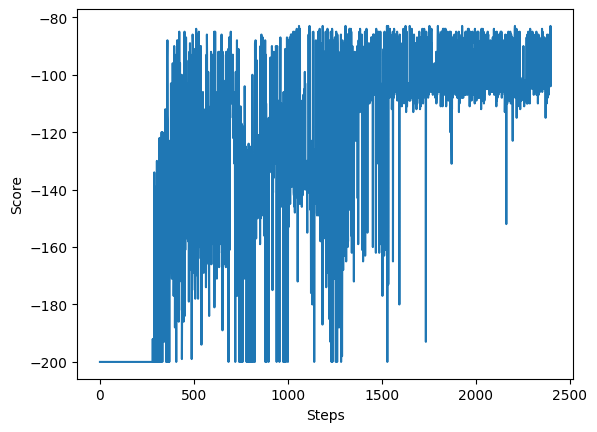

In [23]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [32]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-84.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [34]:
total_rewards = []
num_episodes = 20

for _ in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0.0
    q_net.eval()

    with torch.no_grad():
        while not done:
            action = q_net.choose_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state

    total_rewards.append(total_reward)

average_reward = sum(total_rewards) / num_episodes
print("Average reward over 20 episodes:", average_reward)

Average reward over 20 episodes: -98.45
